In [9]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [10]:
# 1. Get data from API
url = "ur api here"
response = requests.get(url)
data = response.json()

In [11]:
# 2. Convert to DataFrame
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['time_tag'])
df.set_index('timestamp', inplace=True)

In [12]:
# 3. Feature engineering
df['flux_diff'] = df['flux'].diff()  # Calculate flux difference as a feature
df.fillna(0, inplace=True)           # Handle missing values

In [13]:
# 4. Rescale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['flux', 'flux_diff']])

In [14]:
# 5. Create training sequences for LSTM (sequence of past X time steps to predict next step)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the flux
    return np.array(X), np.array(y)

seq_length = 60  # 60 time steps (e.g., past hour of data)
X, y = create_sequences(scaled_data, seq_length)

In [15]:
# 6. Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
# 7. Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))  # Single output (flux prediction)

model.compile(optimizer='adam', loss='mse')

Epoch 1/10
71/71 [==============================] - 21s 142ms/step - loss: 0.9565 - val_loss: 0.4299
Epoch 2/10
71/71 [==============================] - 8s 110ms/step - loss: 0.5158 - val_loss: 0.0119
Epoch 3/10
71/71 [==============================] - 8s 111ms/step - loss: 0.0168 - val_loss: 0.0041
Epoch 4/10
71/71 [==============================] - 8s 109ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 5/10
71/71 [==============================] - 7s 104ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 6/10
71/71 [==============================] - 8s 106ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/10
71/71 [==============================] - 7s 106ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 8/10
71/71 [==============================] - 7s 105ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/10
71/71 [==============================] - 7s 105ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 10/10
18/18 [==============================] - 3s 37ms/step


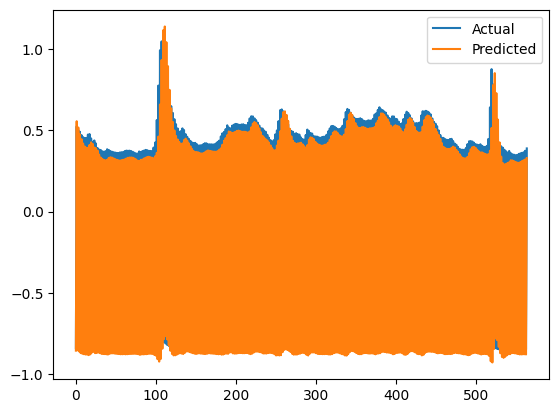

In [17]:
# 8. Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 9. Evaluate and predict
predictions = model.predict(X_test)

# 10. Plot predictions vs actual
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.savefig('prediction_plot.png')
plt.show()

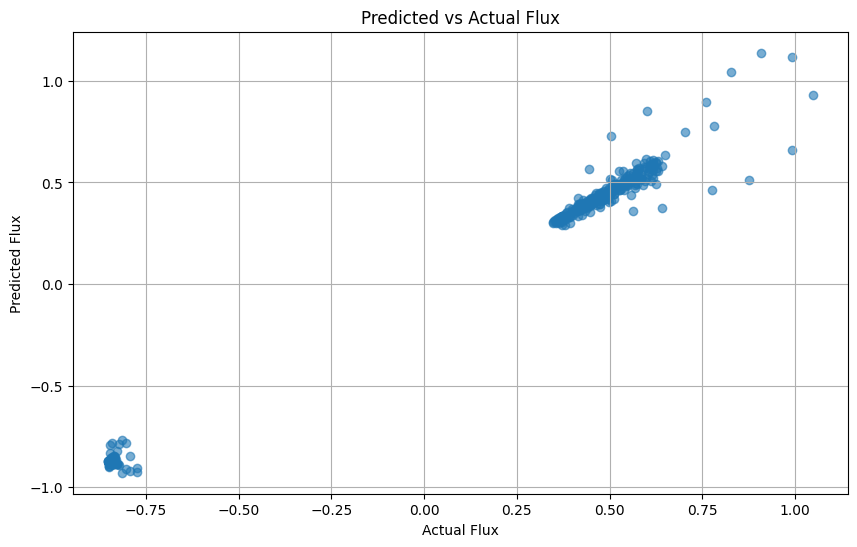

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, label='Predicted vs Actual', alpha=0.6)
plt.title('Predicted vs Actual Flux')
plt.xlabel('Actual Flux')
plt.ylabel('Predicted Flux')
plt.grid(True)
plt.savefig('predicted_vs_actual_scatter.png')
plt.show()

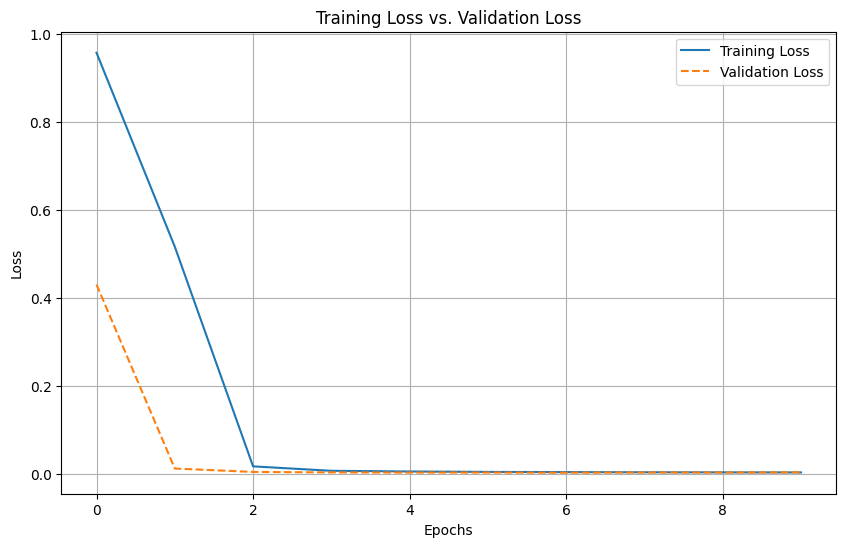

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_vs_val_loss.png')
plt.show()

In [20]:
import json

# Calculate prediction errors (residuals)
errors = y_test - predictions.flatten()  # Calculate the residuals

# Prepare the data
data_dict = {
    'y_test': y_test.tolist(),          # Actual flux values
    'predictions': predictions.flatten().tolist(),  # Predicted flux values
    'errors': errors.tolist()           # Prediction errors (residuals)
}

# Save the dictionary as a JSON file
with open('model_output.json', 'w') as json_file:
    json.dump(data_dict, json_file)

# Alternatively, save the data as CSV
import pandas as pd

output_df = pd.DataFrame({
    'actual_values': y_test,
    'predicted_values': predictions.flatten(),
    'errors': errors  # Residuals
})

# Save DataFrame as CSV
output_df.to_csv('model_output.csv', index=False)